# Basic depth map processing

In [30]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torchvision.models import ResNet18_Weights
import torch
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.model_selection import train_test_split


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

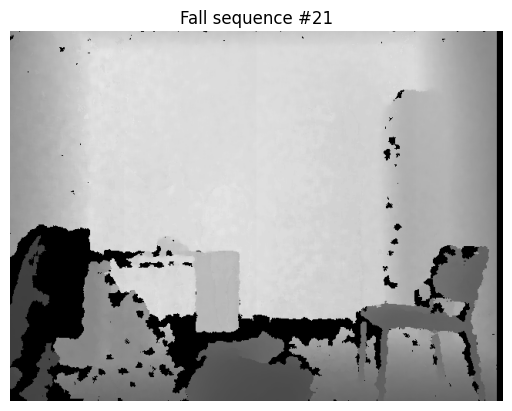

In [31]:
label = 'fall' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:
    frame = cv2.imread(str(frame_path))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.imshow(frame)
    plt.title(f'{label.capitalize()} sequence #{sequence_number}')
    plt.axis('off')
    plt.show()

# Dataset

In [32]:
root = Path('../datasets')
out_root = Path('../data_basic_depth')

if not out_root.exists():
    out_root.mkdir(exist_ok=True)
    for cls in ['adl', 'fall']:
        for seq in (root / cls).iterdir():
            if not seq.is_dir():
                continue

            out_seq = out_root / cls / seq.name
            out_seq.mkdir(parents=True, exist_ok=True)

            for f in sorted(seq.glob('*.png')):
                img = Image.open(f).convert('RGB')
                img = img.resize((128, 128), Image.BILINEAR)
                arr = np.array(img, dtype=np.uint8)  # (H, W, 3)

                np.save(out_seq / f'{f.stem}.npy', arr)


In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=180):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob('*.npy'))
                    if len(frames) > 0:
                        self.samples.append((frames, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        T = len(frame_paths)

        if T >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            frame_paths = [frame_paths[0]] * pad + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f)              # (H, W, 3), uint8
            img = Image.fromarray(arr)    # PIL RGB

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label


In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = VideoDataset(out_root, transform)

### Model

In [35]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        '''
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)

        cnn_features = torch.stack(cnn_features, dim=1)
        lstm_out, _ = self.lstm(cnn_features) 

        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [36]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

summary(model, input_size=(2, 256, 3, 128, 128), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [2, 2]                    --
├─Sequential: 1-1                             [2, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [2, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [2, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [2, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [2, 64, 32, 32]           --
│    └─Sequential: 2-5                        [2, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [2, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2                   [2, 64, 32, 32]           (73,984)
│    └─Sequential: 2-6                        [2, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [2, 128, 16, 16]          (230,144)
│    │    └─BasicBlock: 3-4                   [2, 128, 16, 16]      

### Training

In [37]:
num_epochs = 10
batch_size = 4
num_folds = 10

g = torch.Generator()
g.manual_seed(42)
seed_everything(42)

indices = np.arange(len(dataset))
labels = np.array([dataset[i][1] for i in indices])

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=42
)

checkpoint_dir = Path('../models/basic_depth')
checkpoint_dir.mkdir(exist_ok=True, parents=True)



========== FOLD 1/10 ==========
Epoch [1/10] TRAIN Loss: 0.6853 Acc: 46.03% | VAL Loss: 0.6156 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5480 Acc: 80.95% | VAL Loss: 0.4976 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4392 Acc: 92.06% | VAL Loss: 0.3899 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2488 Acc: 100.00% | VAL Loss: 0.2304 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1580 Acc: 93.65% | VAL Loss: 0.2936 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1154 Acc: 98.41% | VAL Loss: 0.1876 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1258 Acc: 93.65% | VAL Loss: 0.1183 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1248 Acc: 93.65% | VAL Loss: 0.0579 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1773 Acc: 93.65% | VAL Loss: 0.2144 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.2006 Acc: 92.06% | VAL Loss: 0.0739 Acc: 100.00% | LR: 1.00e-04


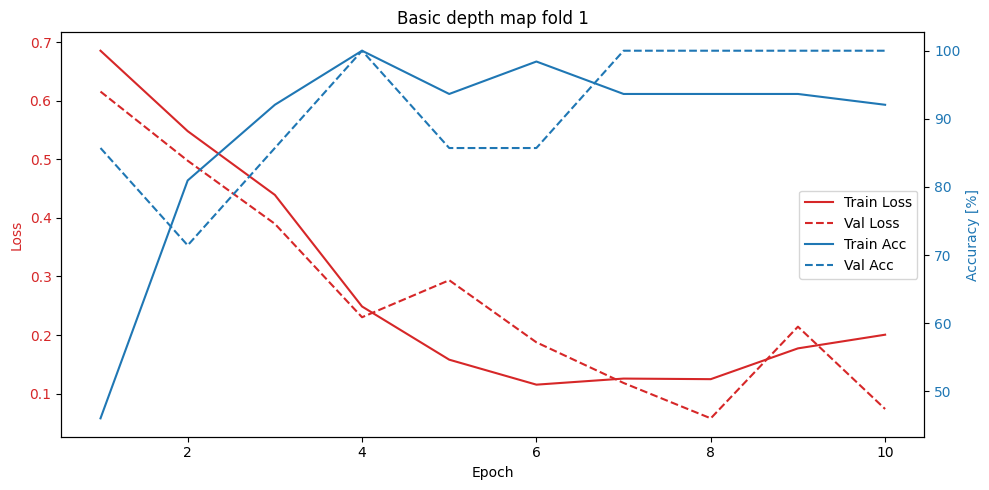


========== FOLD 2/10 ==========
Epoch [1/10] TRAIN Loss: 0.6020 Acc: 65.08% | VAL Loss: 0.5293 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4487 Acc: 98.41% | VAL Loss: 0.4157 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2683 Acc: 100.00% | VAL Loss: 0.2204 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2876 Acc: 93.65% | VAL Loss: 0.7679 Acc: 57.14% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2078 Acc: 93.65% | VAL Loss: 0.1204 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1378 Acc: 96.83% | VAL Loss: 0.1593 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1483 Acc: 96.83% | VAL Loss: 0.6437 Acc: 57.14% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1845 Acc: 93.65% | VAL Loss: 0.1290 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2156 Acc: 93.65% | VAL Loss: 0.2184 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2825 Acc: 87.30% | VAL Loss: 0.1251 Acc: 100.00% | LR: 5.00e-05


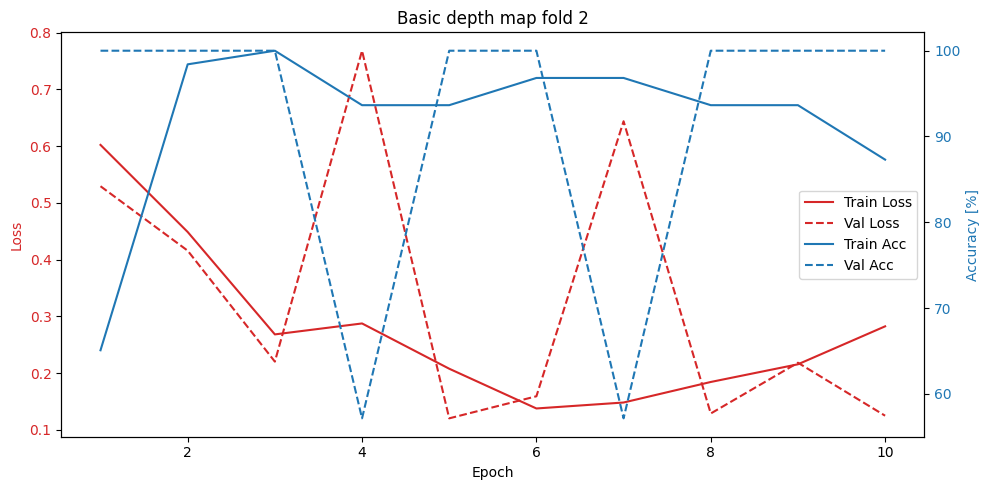


========== FOLD 3/10 ==========
Epoch [1/10] TRAIN Loss: 0.6619 Acc: 55.56% | VAL Loss: 0.6232 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5291 Acc: 82.54% | VAL Loss: 0.5527 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3697 Acc: 90.48% | VAL Loss: 0.3850 Acc: 71.43% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3523 Acc: 85.71% | VAL Loss: 0.1819 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2156 Acc: 93.65% | VAL Loss: 0.3613 Acc: 71.43% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2849 Acc: 87.30% | VAL Loss: 0.3595 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1852 Acc: 93.65% | VAL Loss: 0.5840 Acc: 57.14% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.2993 Acc: 85.71% | VAL Loss: 0.1600 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1917 Acc: 93.65% | VAL Loss: 0.1926 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1536 Acc: 96.83% | VAL Loss: 0.3021 Acc: 71.43% | LR: 5.00e-05


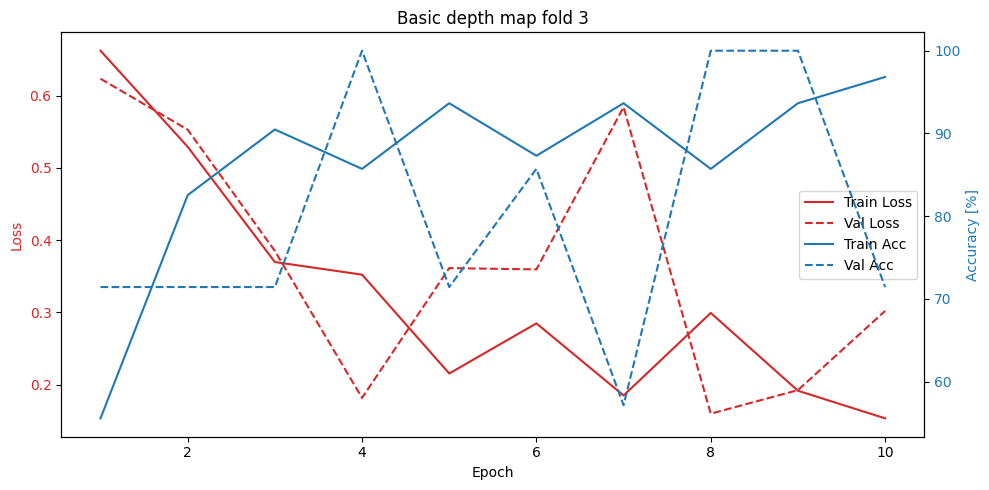


========== FOLD 4/10 ==========
Epoch [1/10] TRAIN Loss: 0.5982 Acc: 74.60% | VAL Loss: 0.4969 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4822 Acc: 88.89% | VAL Loss: 0.4337 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3795 Acc: 85.71% | VAL Loss: 0.2721 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2172 Acc: 100.00% | VAL Loss: 0.1848 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0910 Acc: 98.41% | VAL Loss: 0.2386 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1322 Acc: 95.24% | VAL Loss: 0.1055 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0250 Acc: 100.00% | VAL Loss: 0.4778 Acc: 57.14% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0245 Acc: 100.00% | VAL Loss: 0.0750 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2561 Acc: 88.89% | VAL Loss: 0.0344 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.2182 Acc: 92.06% | VAL Loss: 0.0935 Acc: 100.00% | LR: 1.00e-04


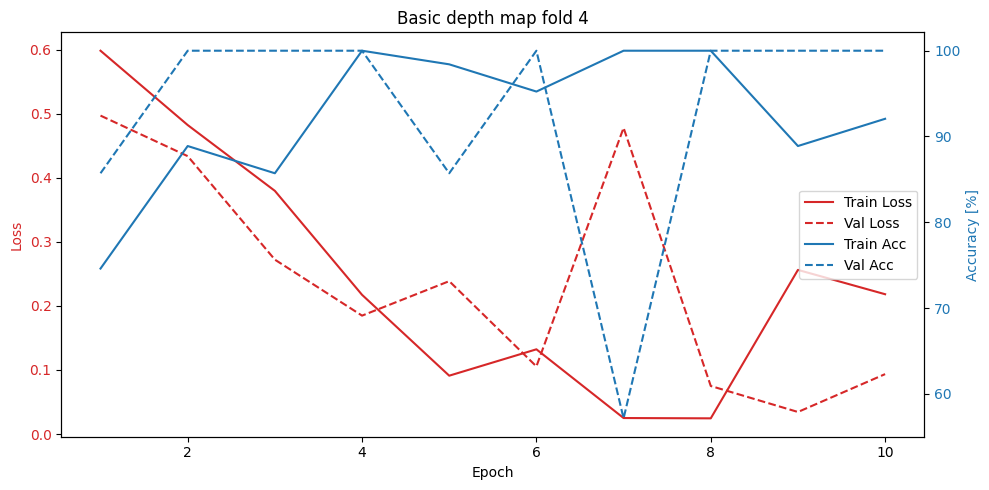


========== FOLD 5/10 ==========
Epoch [1/10] TRAIN Loss: 0.6257 Acc: 68.25% | VAL Loss: 0.5869 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5131 Acc: 84.13% | VAL Loss: 0.5147 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3967 Acc: 92.06% | VAL Loss: 0.3577 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2767 Acc: 95.24% | VAL Loss: 0.2788 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1504 Acc: 98.41% | VAL Loss: 0.1806 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1064 Acc: 96.83% | VAL Loss: 0.2134 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2518 Acc: 85.71% | VAL Loss: 0.2229 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0943 Acc: 100.00% | VAL Loss: 0.1109 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2490 Acc: 93.65% | VAL Loss: 0.3882 Acc: 57.14% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1562 Acc: 93.65% | VAL Loss: 0.6469 Acc: 57.14% | LR: 1.00e-04


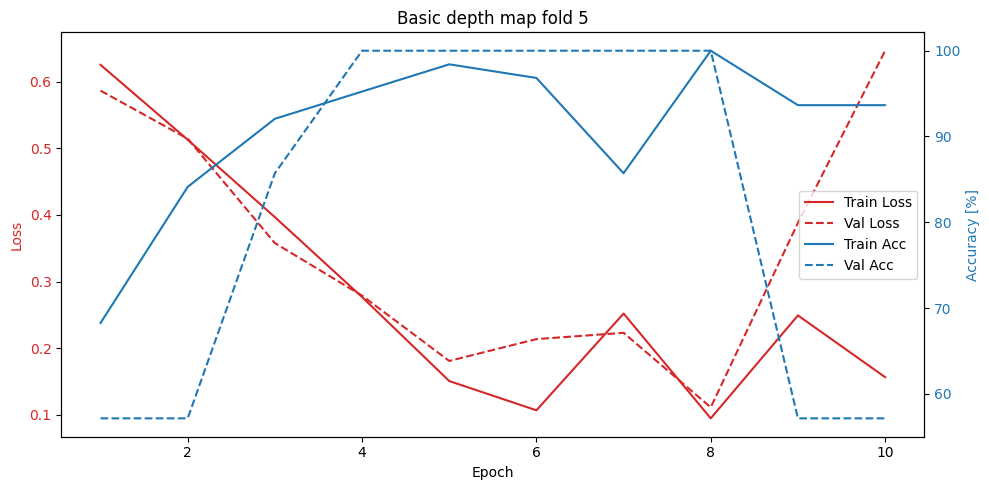


========== FOLD 6/10 ==========
Epoch [1/10] TRAIN Loss: 0.7281 Acc: 52.38% | VAL Loss: 0.6541 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5736 Acc: 61.90% | VAL Loss: 0.5841 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4828 Acc: 82.54% | VAL Loss: 0.4900 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3570 Acc: 90.48% | VAL Loss: 0.6458 Acc: 57.14% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2658 Acc: 96.83% | VAL Loss: 0.2296 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2109 Acc: 92.06% | VAL Loss: 0.1387 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1600 Acc: 95.24% | VAL Loss: 0.1271 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1642 Acc: 93.65% | VAL Loss: 0.2638 Acc: 85.71% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1401 Acc: 96.83% | VAL Loss: 0.1808 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.2566 Acc: 92.06% | VAL Loss: 0.0689 Acc: 100.00% | LR: 1.00e-04


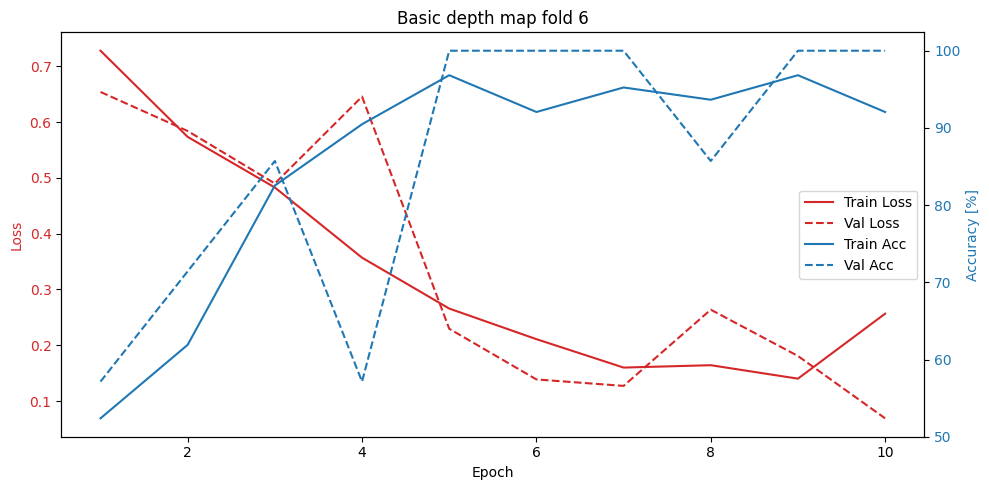


========== FOLD 7/10 ==========
Epoch [1/10] TRAIN Loss: 0.6008 Acc: 73.02% | VAL Loss: 0.4971 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4598 Acc: 92.06% | VAL Loss: 0.4179 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2956 Acc: 93.65% | VAL Loss: 0.2537 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1507 Acc: 100.00% | VAL Loss: 0.2262 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.3616 Acc: 82.54% | VAL Loss: 0.1707 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.4811 Acc: 82.54% | VAL Loss: 0.1671 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2596 Acc: 87.30% | VAL Loss: 0.2061 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2476 Acc: 88.89% | VAL Loss: 0.1407 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2118 Acc: 90.48% | VAL Loss: 0.2591 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1904 Acc: 90.48% | VAL Loss: 0.8685 Acc: 57.14% | LR: 1.00e-04


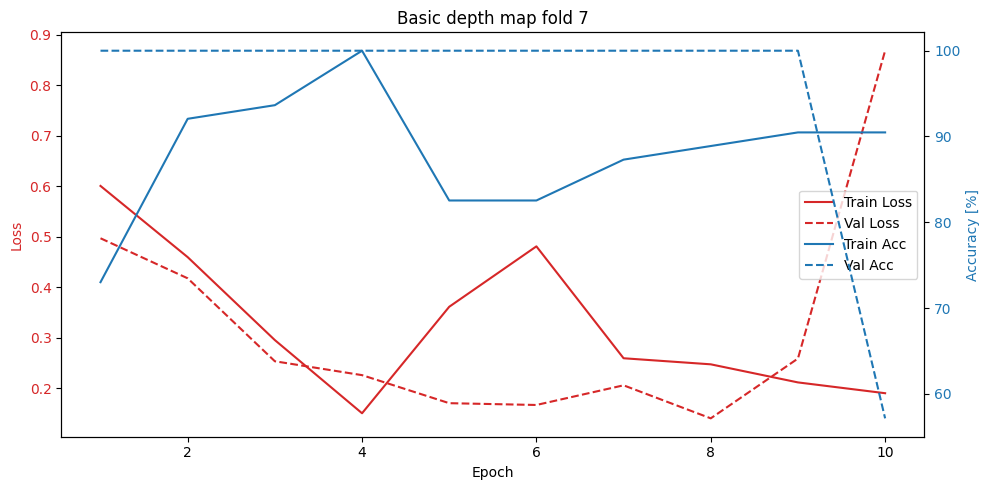


========== FOLD 8/10 ==========
Epoch [1/10] TRAIN Loss: 0.6511 Acc: 58.73% | VAL Loss: 0.5825 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5301 Acc: 79.37% | VAL Loss: 0.5459 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4553 Acc: 82.54% | VAL Loss: 0.4590 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2612 Acc: 98.41% | VAL Loss: 0.3300 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1409 Acc: 100.00% | VAL Loss: 0.2450 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2566 Acc: 88.89% | VAL Loss: 0.1782 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0966 Acc: 100.00% | VAL Loss: 0.1923 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0437 Acc: 100.00% | VAL Loss: 0.1935 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0358 Acc: 100.00% | VAL Loss: 0.1659 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0242 Acc: 100.00% | VAL Loss: 0.3093 Acc: 71.43% | LR: 1.00e-04


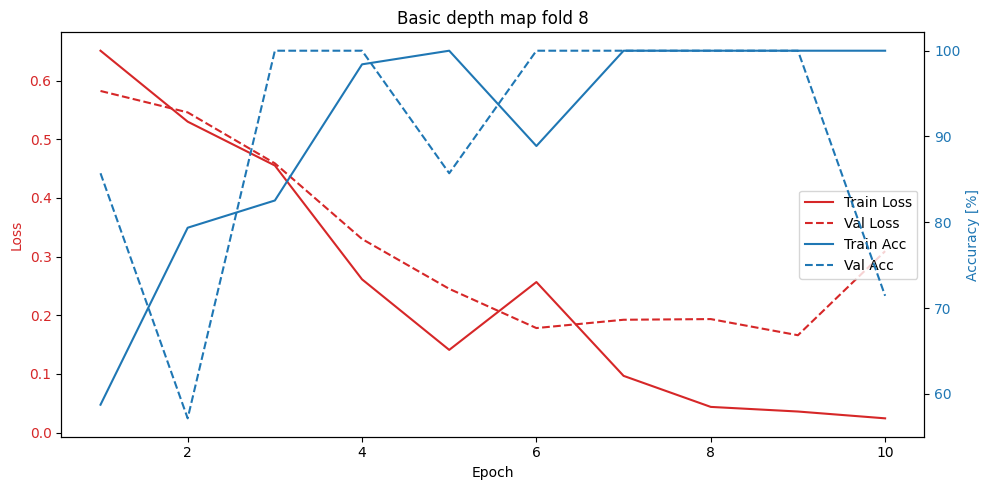


========== FOLD 9/10 ==========
Epoch [1/10] TRAIN Loss: 0.6818 Acc: 55.56% | VAL Loss: 0.5604 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4998 Acc: 92.06% | VAL Loss: 0.4174 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4389 Acc: 87.30% | VAL Loss: 0.3669 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.4323 Acc: 82.54% | VAL Loss: 0.4377 Acc: 57.14% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.3072 Acc: 87.30% | VAL Loss: 0.1762 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1523 Acc: 100.00% | VAL Loss: 0.1454 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1527 Acc: 93.65% | VAL Loss: 0.1852 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0955 Acc: 98.41% | VAL Loss: 0.0477 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1172 Acc: 96.83% | VAL Loss: 0.0560 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1213 Acc: 96.83% | VAL Loss: 0.6106 Acc: 57.14% | LR: 1.00e-04


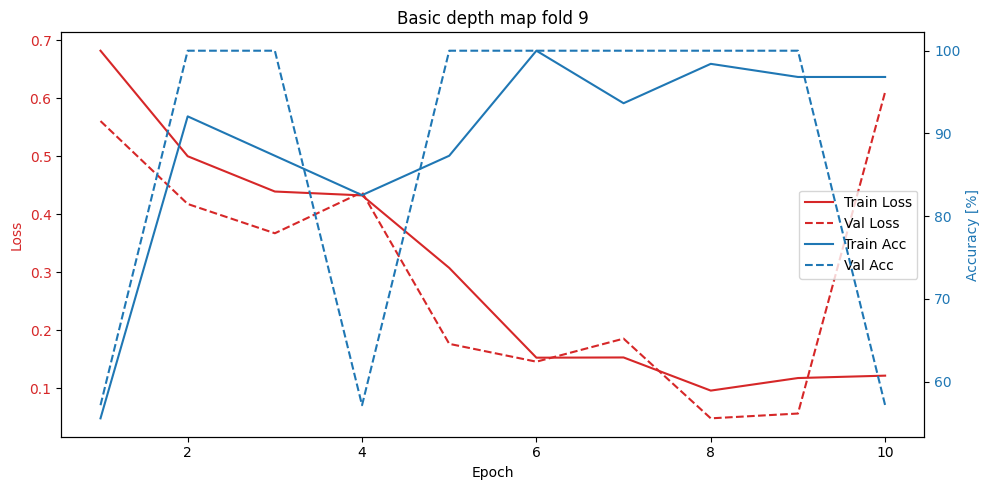


========== FOLD 10/10 ==========
Epoch [1/10] TRAIN Loss: 0.6424 Acc: 63.49% | VAL Loss: 0.6233 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5132 Acc: 87.30% | VAL Loss: 0.4378 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3779 Acc: 88.89% | VAL Loss: 0.3374 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2532 Acc: 92.06% | VAL Loss: 0.3092 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1340 Acc: 100.00% | VAL Loss: 0.1217 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2652 Acc: 88.89% | VAL Loss: 0.2228 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1639 Acc: 95.24% | VAL Loss: 0.5342 Acc: 57.14% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1078 Acc: 96.83% | VAL Loss: 0.2581 Acc: 85.71% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1225 Acc: 95.24% | VAL Loss: 0.0900 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.0812 Acc: 96.83% | VAL Loss: 0.1114 Acc: 100.00% | LR: 5.00e-05


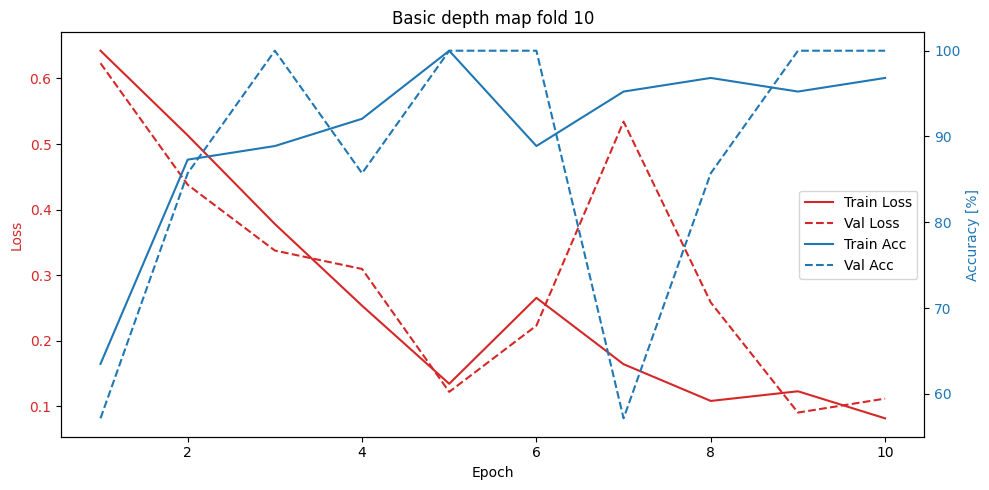

In [38]:
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f'\n========== FOLD {fold+1}/{num_folds} ==========')

    model = CNN_LSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    best_val_loss = 1e10
    best_model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # ===================== TRAIN =====================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for videos, y in train_loader:
            videos = videos.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss /= len(train_dataset)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===================== VAL =====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, y in val_loader:
                videos = videos.to(device)
                y = y.to(device)

                outputs = model(videos)
                loss = criterion(outputs, y)

                val_loss += loss.item() * videos.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        
        val_loss /= len(val_dataset)
        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f'Epoch [{epoch+1}/{num_epochs}] '
            f'TRAIN Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
            f'VAL Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | '
            f'LR: {current_lr:.2e}'
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # ===================== PLOT =====================
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy [%]', color='tab:blue')
    ax2.plot(epochs, train_accs, label='Train Acc', color='tab:blue')
    ax2.plot(epochs, val_accs, label='Val Acc', color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    plt.title(f'Basic depth map fold {fold+1}')
    plt.tight_layout()
    plt.show()

In [39]:
print('\n========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========')

final_results = []

full_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    generator=g
)

for fold in range(num_folds):
    model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'
    print(f'\nFold {fold+1}:')

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        error_fragments = []
        for batch_idx, (videos, y) in enumerate(full_loader):
            videos = videos.to(device)
            y = y.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            incorrect_idx = (preds != y).nonzero(as_tuple=True)[0]

            start_idx = batch_idx * full_loader.batch_size
            global_incorrect_idx = start_idx + incorrect_idx

            for idx in global_incorrect_idx:
                full_path = full_loader.dataset.samples[idx.item()][0]
                full_path_str = str(full_path)
                parts = full_path_str.split('/')[-3:-1]
                fragment = '/'.join(parts)
                error_fragments.append(fragment)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    if error_fragments:
        print("Errors:")
        for f in error_fragments:
            print(f)

    metrics = {
        'fold': fold,
        'acc': accuracy_score(all_labels, all_preds),
        'prec': precision_score(all_labels, all_preds, average='binary'),
        'rec': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary'),
    }

    final_results.append(metrics)
    print(metrics)



========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========

Fold 1:
{'fold': 0, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 2:
{'fold': 1, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 3:
Errors:
adl/sequence-32
adl/sequence-33
adl/sequence-35
{'fold': 2, 'acc': 0.9571428571428572, 'prec': 0.9090909090909091, 'rec': 1.0, 'f1': 0.9523809523809523}

Fold 4:
{'fold': 3, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 5:
{'fold': 4, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 6:
{'fold': 5, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 7:
{'fold': 6, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 8:
{'fold': 7, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 9:
{'fold': 8, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 10:
{'fold': 9, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}


In [40]:
print('\n========== CV RESULTS ==========')

for metric in final_results[0].keys():
    if metric == 'fold':
        continue
    values = [f[metric] for f in final_results]
    print(
        f'{metric.upper()}: '
        f'{np.mean(values)*100:.2f}% std: {np.std(values)*100:.2f}%'
    )



========== CV RESULTS ==========
ACC: 99.57% std: 1.29%
PREC: 99.09% std: 2.73%
REC: 100.00% std: 0.00%
F1: 99.52% std: 1.43%
